## Installing package dependencies

In [35]:
# install the necessary libraries

!pip install datasets

## Import the required packages

In [36]:
## import packages

import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import datasets
import transformers
from transformers import BertTokenizer, BertModel
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from transformers import GPT2Tokenizer, GPT2LMHeadModel

## Section 1

### Vector Database creation

Dataset Link: https://huggingface.co/datasets/nateraw/pascal-voc-2012



In [37]:
# Implement the function to create vector database

## Load the dataset
# Load the dataset (Pascal VOC 2012)
dataset = datasets.load_dataset('nateraw/pascal-voc-2012', split='train')

In [38]:
# Define image preprocessing
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load pre-trained ResNet model
model = models.resnet50(pretrained=True)
model.eval()

# Remove the fully connected layer to extract features
model = nn.Sequential(*list(model.children())[:-1])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [39]:
# Create and store the vector database. Feel free to add any helper functions if you need

# Create Image Vectors Database
vector_db = []

# Function to extract features from an image
def extract_features(image):
    with torch.no_grad():
        features = model(image.unsqueeze(0))
    return features.squeeze()

# Function to add image vectors to the database
def create_vector_db():
    global vector_db
    for idx, image_data in enumerate(dataset):
        image = image_data['image']
        image_tensor = preprocess(image)
        image_features = extract_features(image_tensor).numpy()
        vector_db.append(image_features)
    vector_db = np.array(vector_db)
    np.save('vector_database.npy', vector_db)
    print("Vector Database created successfully!")

# Create the vector database
create_vector_db()

Vector Database created successfully!


## Section 2

Implement search functionlity

In [40]:
# Load the vector database
vector_db = np.load('vector_database.npy')

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [41]:
# Search function

# Function to extract features from an image
def extract_features(image):
    with torch.no_grad():
        features = model(image.unsqueeze(0))
    return features.squeeze()

# Function to extract features from text using BERT
def extract_features_from_text(text):
    tokens = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        outputs = bert_model(**tokens)
        last_hidden_states = outputs.last_hidden_state
        # Mean pooling of BERT outputs
        text_features = torch.mean(last_hidden_states, dim=1)
    return text_features

# Function to reduce dimensionality of image vectors using PCA
def reduce_dimensionality(vectors, target_dim):
    pca = PCA(n_components=target_dim)
    vectors_reduced = pca.fit_transform(vectors)
    return vectors_reduced

# Reduce dimensionality of image vectors to match BERT vectors
vector_db_reduced = reduce_dimensionality(vector_db, 768)

# Function to search for similar images based on text query
def search_similar_images_with_text(query_text, top_k=5):
    # Extract features from the query text
    query_text_features = extract_features_from_text(query_text)
    query_text_features = query_text_features.squeeze().numpy()

    # Calculate cosine similarity between query text features and reduced image vectors
    similarities = cosine_similarity([query_text_features], vector_db_reduced)

    # Get indices of most similar images
    similar_image_indices = np.argsort(similarities[0])[::-1][:top_k]

    # Get the actual images and their similarity scores
    similar_images = [(dataset[int(idx)]['image'], similarities[0][idx]) for idx in similar_image_indices]

    return similar_images

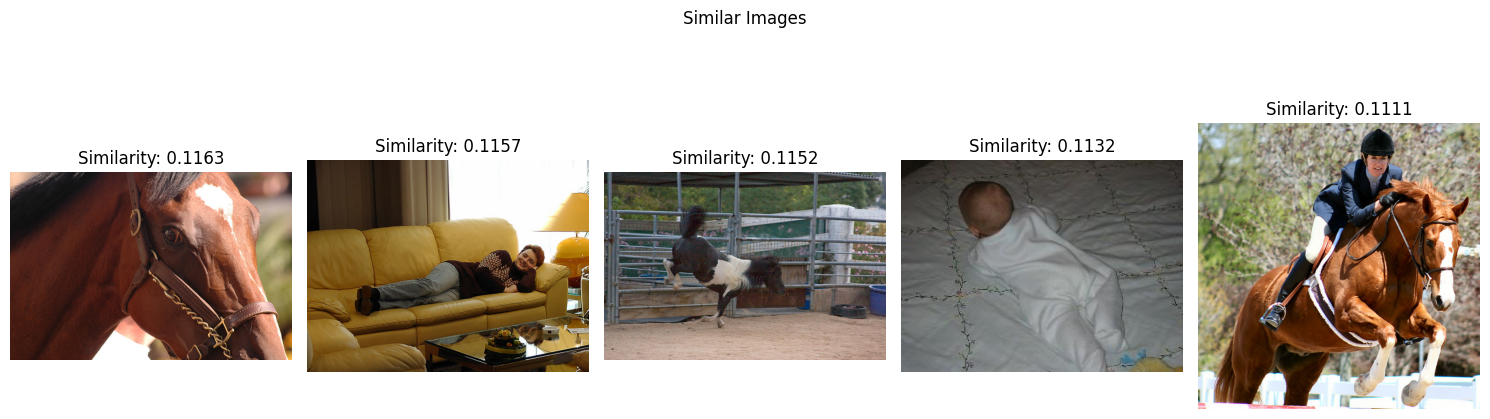

In [42]:
# Example usage:
query_text = "Eiffel Tower"
similar_images = search_similar_images_with_text(query_text, top_k=5)

# Display or use the similar images as needed
fig, axs = plt.subplots(1, len(similar_images), figsize=(15, 5))
fig.suptitle("Similar Images")

for i, (img, similarity) in enumerate(similar_images):
    ax = axs[i]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Similarity: {similarity:.4f}")

plt.tight_layout()
plt.show()

## Section 3

LLM output

In [43]:
# Load any relevant LLM (You can use huggingface to load and perform other task)

# Load pre-trained GPT2 model and tokenizer

# Load pre-trained GPT-2 model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

In [44]:
# Generate the description for the input query

# Function to generate description using GPT-2 model
def generate_description(query_text):
    input_ids = tokenizer.encode(query_text, return_tensors='pt')
    with torch.no_grad():
        output = model.generate(input_ids, max_length=100, num_return_sequences=1, no_repeat_ngram_size=2)
    description = tokenizer.decode(output[0], skip_special_tokens=True)
    return description

# Example usage:
query_text = "The Eiffel Tower"
description = generate_description(query_text)
print("Generated Description:")
print(description)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Description:
The Eiffel Tower is a landmark in the city of London, and is the tallest building in London. It is also the only building to have a single-story tower.

The tower is located in a building called the Eiffs Tower, which is built on the site of the famous E.F. Kennedy Tower. The EIFFEL Tower was built in 1885, but was demolished in 1973.
